In [7]:
import pandas as pd
import numpy as np
import time

import requests
import random
from io import StringIO
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Union, Dict, List

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

In [8]:
import ipywidgets as widgets
from IPython.display import display

## Data Loading

In [9]:
file = './processed_data/NC_processed_data_1_6.parquet'

In [ ]:
df = pd.read_parquet(file)
df

In [ ]:
df.columns

## Splitting Data for ML 

In [12]:
def split_data_temporal(df, final_cutoff='2024-09-28', train_pct=0.6, test_pct=0.2, val_pct=0.2):
    """
    Split data into training, testing, validation, and true test sets based on dates
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input DataFrame with a 'date' column
    final_cutoff : str
        Date string for the cutoff between validation and true test sets
    train_pct : float
        Percentage of pre-cutoff data to use for training (default: 0.6)
    test_pct : float
        Percentage of pre-cutoff data to use for testing (default: 0.2)
    val_pct : float
        Percentage of pre-cutoff data to use for validation (default: 0.2)
    """
    # Input validation
    if not abs(train_pct + test_pct + val_pct - 1.0) < 1e-10:
        raise ValueError("Training, testing, and validation percentages must sum to 1.0")
    
    # Convert dates to pandas datetime
    final_cutoff = pd.to_datetime(final_cutoff)
    
    # Create mask for true test set
    true_test_mask = df['date'] > final_cutoff
    
    # Get the remaining data (everything up to final_cutoff)
    remaining_data = df[~true_test_mask].copy()
    remaining_data = remaining_data.sort_values('date')
    
    # Calculate the split points based on percentages
    n_samples = len(remaining_data)
    train_end_idx = int(n_samples * train_pct)
    test_end_idx = int(n_samples * (train_pct + test_pct))
    
    # Get the dates at these split points
    train_cutoff = remaining_data.iloc[train_end_idx]['date']
    test_cutoff = remaining_data.iloc[test_end_idx]['date']
    
    # Create masks for each period
    validation_mask = (df['date'] <= final_cutoff) & (df['date'] > test_cutoff)
    test_mask = (df['date'] <= test_cutoff) & (df['date'] > train_cutoff)
    train_mask = df['date'] <= train_cutoff
    
    # Split the data
    # Exclude observation_datetime, year_index, and date from features
    X_cols = [col for col in df.columns 
              if 'MITC' not in col 
              and col not in ['observation_datetime', 'year_index', 'date']]
    y_cols = [col for col in df.columns if 'MITC' in col]
    
    # Create the splits
    X_train = df.loc[train_mask, X_cols]
    y_train = df.loc[train_mask, y_cols]
    
    X_test = df.loc[test_mask, X_cols]
    y_test = df.loc[test_mask, y_cols]
    
    X_val = df.loc[validation_mask, X_cols]
    y_val = df.loc[validation_mask, y_cols]
    
    X_true_test = df.loc[true_test_mask, X_cols]
    y_true_test = df.loc[true_test_mask, y_cols]
    
    # Print summary statistics
    print("Data split summary:")
    print(f"Training period: {df.loc[train_mask, 'date'].min()} to {df.loc[train_mask, 'date'].max()}")
    print(f"Training samples: {len(X_train)} ({len(X_train)/len(remaining_data):.1%} of pre-cutoff data)")
    
    print(f"\nTesting period: {df.loc[test_mask, 'date'].min()} to {df.loc[test_mask, 'date'].max()}")
    print(f"Testing samples: {len(X_test)} ({len(X_test)/len(remaining_data):.1%} of pre-cutoff data)")
    
    print(f"\nValidation period: {df.loc[validation_mask, 'date'].min()} to {df.loc[validation_mask, 'date'].max()}")
    print(f"Validation samples: {len(X_val)} ({len(X_val)/len(remaining_data):.1%} of pre-cutoff data)")
    
    print(f"\nTrue test period: {df.loc[true_test_mask, 'date'].min()} to {df.loc[true_test_mask, 'date'].max()}")
    print(f"True test samples: {len(X_true_test)}")
    
    print("\nFeatures used:")
    print(X_cols)
    
    return (X_train, y_train, X_test, y_test, X_val, y_val, X_true_test, y_true_test)

## Picking how much data goes where:

In [13]:
def create_percentage_widget():
    # Create text widgets for percentages
    training = widgets.BoundedIntText(
        value=70,
        min=0,
        max=100,
        description='Training %:',
        layout=widgets.Layout(width='200px')
    )
    
    testing = widgets.BoundedIntText(
        value=20,
        min=0,
        max=100,
        description='Testing %:',
        layout=widgets.Layout(width='200px')
    )
    
    validation = widgets.BoundedIntText(
        value=10,
        min=0,
        max=100,
        description='Validation %:',
        layout=widgets.Layout(width='200px')
    )
    
    output = widgets.Output()
    
    def check_percentages(change):
        with output:
            output.clear_output()
            total = training.value + testing.value + validation.value
      
            print(f"\nTotal: {total}%")
            
            if total == 100:
                print("✓ Perfect! Percentages sum to 100%")
            else:
                print(f"✗ Warning: Percentages sum to {total}%, not 100%")
    
    # Add observers
    training.observe(check_percentages, names='value')
    testing.observe(check_percentages, names='value')
    validation.observe(check_percentages, names='value')
    
    # Layout
    widget_box = widgets.VBox([
        widgets.HTML(value="<h3>Dataset Split Percentages</h3>"),
        training,
        testing,
        validation,
        output
    ])
    
    display(widget_box)
    
    # Return both the widget box and a function to get decimal values
    def get_decimal_values():
        return {
            'training': training.value / 100,
            'testing': testing.value / 100,
            'validation': validation.value / 100
        }
    
    return widget_box, get_decimal_values

In [ ]:
widget, get_values = create_percentage_widget()

In [15]:
decimals = get_values()
training = decimals['training']    # 0.7 for 70%
testing = decimals['testing']      # 0.2 for 20%
validation = decimals['validation'] # 0.1 for 10%

In [ ]:
# Use the function
X_train, y_train, X_test, y_test, X_val, y_val, X_true_test, y_true_test = split_data_temporal(df, 
                                                                                               train_pct=training, 
                                                                                               test_pct=testing, 
                                                                                               val_pct=validation)

In [ ]:
X_train

## Site Selector

In [12]:
def create_station_selector():
    # List of all stations
    stations = ['BURN', 'NCAT', 'SALI', 'SASS', 'FRYI', 'JEFF', 'BEAR', 'WINE', 'UNCA']
    
    # Create checkbox widgets for each station
    checkboxes = {
        station: widgets.Checkbox(
            value=False,
            description=station,
            disabled=False,
            indent=False
        ) for station in stations
    }
    
    # Create a container for all checkboxes
    checkbox_grid = widgets.GridBox(
        children=[checkboxes[station] for station in stations],
        layout=widgets.Layout(
            grid_template_columns='repeat(3, auto)',
            grid_gap='10px'
        )
    )
    
    # Function to get selected stations
    def get_selected_stations():
        return [station for station, checkbox in checkboxes.items() if checkbox.value]
    
    # Create an output widget to display selected stations
    output = widgets.Output()
    
    # Update function for when checkboxes change
    def on_change(change):
        with output:
            output.clear_output()
            selected = get_selected_stations()
            print(f"Selected stations: {', '.join(selected) if selected else 'None'}")
    
    # Add observers to all checkboxes
    for checkbox in checkboxes.values():
        checkbox.observe(on_change, names='value')
    
    # Display everything
    display(widgets.VBox([
        widgets.HTML(value="<h3>Select Weather Stations</h3>"),
        checkbox_grid,
        output
    ]))
    
    return checkboxes

In [ ]:
station_selector = create_station_selector()

In [ ]:
# To get selected stations at any time:
def get_selected_stations(selector):
    return [station for station, checkbox in selector.items() if checkbox.value]

selected = get_selected_stations(station_selector)
selected 

In [ ]:
X_train.columns

In [27]:
def filter_dataframe(df, prefix_values):
    """
    Filter DataFrame to keep only columns with specified prefixes plus day_index and hour_index.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    prefix_values (list): List of prefix values to match
    
    Returns:
    pandas.DataFrame: Filtered DataFrame with only the specified columns
    """
    # Print original column count
    print(f"Original DataFrame: {len(df.columns)} columns")
    
    # Start with day_index and hour_index
    columns_to_keep = ['day_index', 'hour_index']
    
    # Add any column that starts with our prefix values
    for prefix in prefix_values:
        matching_columns = [col for col in df.columns if col.startswith(prefix)]
        columns_to_keep.extend(matching_columns)
    
    # Create filtered dataframe
    filtered_df = df[columns_to_keep]
    
    # Print new column count
    print(f"Filtered DataFrame: {len(filtered_df.columns)} columns")
    
    return filtered_df

In [ ]:
X_train_filtered = filter_dataframe(X_train, selected)

In [ ]:
X_val_filtered = filter_dataframe(X_val, selected)

In [ ]:
X_test_filtered = filter_dataframe(X_test, selected)

In [ ]:
X_true_test_filtered = filter_dataframe(X_true_test, selected)

<h3>Choose algo</h3>

<h3>Train Model</h3>

In [ ]:
class MultiXGBRegressor(MultiOutputRegressor):
    def __init__(self, estimator):
        super().__init__(estimator)
        self.estimators_ = []

    def fit(self, X, y):
        start_time = time.time()
        print("\nStarting Multi-Target XGBoost Training Process...")
        y_np = y.values if hasattr(y, 'values') else np.array(y)
        n_outputs = y_np.shape[1]
        target_names = y.columns if hasattr(y, 'columns') else [f"target_{i}" for i in range(n_outputs)]
        
        self.estimators_ = [
            XGBRegressor(**{k: v for k, v in self.estimator.get_params().items() 
                          if k != 'verbose'}) 
            for _ in range(n_outputs)
        ]
        
        for i, (est, target) in enumerate(zip(self.estimators_, target_names)):
            target_start = time.time()
            print(f"\nTraining target {i+1}/{n_outputs}: {target}", flush=True)
            est.fit(X, y_np[:, i], verbose=False)
            target_time = time.time() - target_start
            print(f"Target completed in {target_time:.2f} seconds", flush=True)

        total_time = time.time() - start_time
        print(f"\nTotal training completed in {total_time:.2f} seconds")
        return self

base_model = XGBRegressor(
    n_estimators=100,
    tree_method='hist',
    random_state=42
)
model = MultiXGBRegressor(base_model)
model.fit(X_train_filtered, y_train)

In [ ]:

class MultiLinearRegressor(MultiOutputRegressor):
    def __init__(self):
        super().__init__(LinearRegression())
        self.estimators_ = []

    def fit(self, X, y):
        start_time = time.time()
        print("\nStarting Multi-Target Linear Regression Training...")
        y_np = y.values if hasattr(y, 'values') else np.array(y)
        n_outputs = y_np.shape[1]
        target_names = y.columns if hasattr(y, 'columns') else [f"target_{i}" for i in range(n_outputs)]
        
        self.estimators_ = [LinearRegression() for _ in range(n_outputs)]
        
        for i, (est, target) in enumerate(zip(self.estimators_, target_names)):
            target_start = time.time()
            print(f"\nTraining target {i+1}/{n_outputs}: {target}", flush=True)
            est.fit(X, y_np[:, i])
            target_time = time.time() - target_start
            print(f"Target completed in {target_time:.2f} seconds", flush=True)

        total_time = time.time() - start_time
        print(f"\nTotal training completed in {total_time:.2f} seconds")
        return self

model = MultiLinearRegressor()
model.fit(X_train_filtered, y_train)

<h4>Validate Model + Evaluate and Refine</h4>

In [ ]:
# Make predictions
y_pred = model.predict(X_test_filtered)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

# Print results
print("Mean Squared Error for each target:")
for target, error in zip(y_test.columns, mse):
    print(f"{target}: {error:.4f}")

print("\nRoot Mean Squared Error for each target:")
for target, error in zip(y_test.columns, rmse):
    print(f"{target}: {error:.4f}")

print("\nR2 Score for each target:")
for target, score in zip(y_test.columns, r2):
    print(f"{target}: {score:.4f}")

# Overall performance
print(f"Average RMSE: {np.mean(rmse):.2f}")
print(f"Average R2 Score: {np.mean(r2):.2f}")

<h4>Test Model + Evaluate and Justify</h4>

In [ ]:
# Make predictions
y_pred = model.predict(X_val_filtered)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(y_val, y_pred, multioutput='raw_values')

# Print results
print("Mean Squared Error for each target:")
for target, error in zip(y_val.columns, mse):
    print(f"{target}: {error:.4f}")

print("\nRoot Mean Squared Error for each target:")
for target, error in zip(y_val.columns, rmse):
    print(f"{target}: {error:.4f}")

print("\nR2 Score for each target:")
for target, score in zip(y_val.columns, r2):
    print(f"{target}: {score:.4f}")

# Overall performance
print(f"\nAverage MSE: {np.mean(mse):.2f}")
print(f"Average RMSE: {np.mean(rmse):.2f}")
print(f"Average R2 Score: {np.mean(r2):.2f}")

# Add new data here??
To round out the full framework 
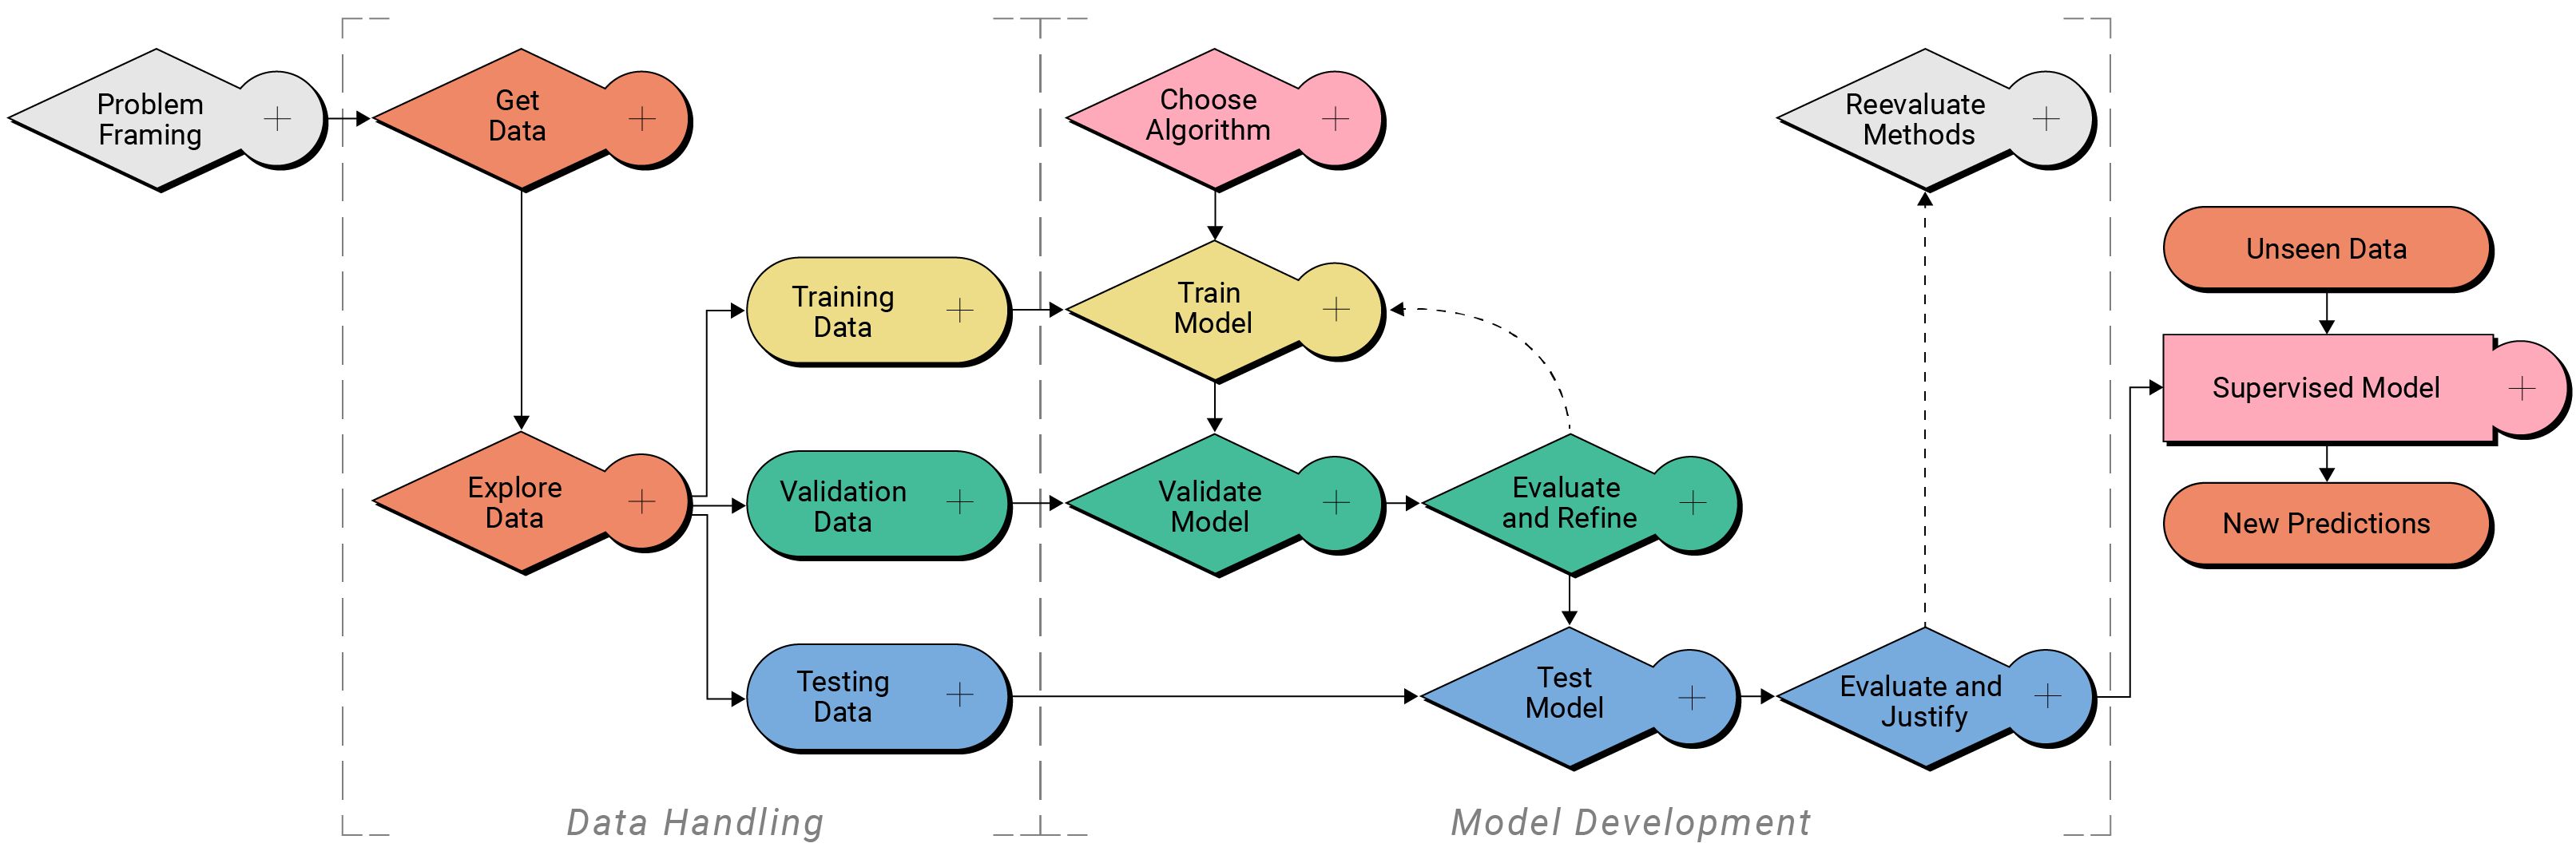